In [95]:
!pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [96]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.decomposition import PCA

from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [97]:
df=pd.read_csv('file:///C:/Users/Md%20Asif%20Ikbal/Downloads/bmi.csv')
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [98]:
target = 'Index'
labels = ['Extremely Weak','Weak','Normal','Overweight','Obsesity','Extreme Obesity']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3



Inference: The Datset consists of 4 features & 500 samples.


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [100]:
df.index

RangeIndex(start=0, stop=500, step=1)

In [101]:
df.isnull().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [102]:
df.describe()

,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


In [103]:
df.corr().describe().T

,count,mean,std,min,25%,50%,75%,max
Height,3.0,0.192741,0.730351,-0.422223,-0.210888,0.000446,0.500223,1.0
Weight,3.0,0.601672,0.529767,0.000446,0.402508,0.804569,0.902285,1.0
Index,3.0,0.460782,0.770923,-0.422223,0.191173,0.804569,0.902285,1.0


In [104]:
df.mean()

Height    169.944
Weight    106.000
Index       3.748
dtype: float64

In [105]:
df.min()

Gender    Female
Height       140
Weight        50
Index          0
dtype: object

In [106]:
df.max()

Gender    Male
Height     199
Weight     160
Index        5
dtype: object

In [107]:
df.nunique()

Gender      2
Height     60
Weight    110
Index       6
dtype: int64

In [108]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 2 numerical & 1 categorical features.


            Target Variable Distribution           


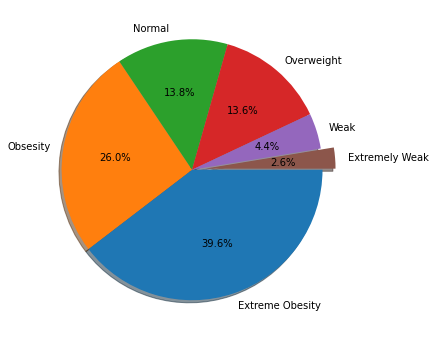

In [109]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

                               Visualising Categorical Features:                                


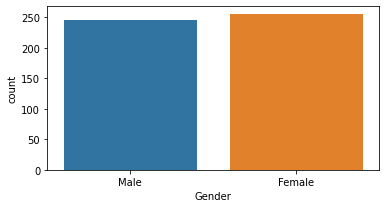

In [110]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=6:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

                                     Features Distribution                                      


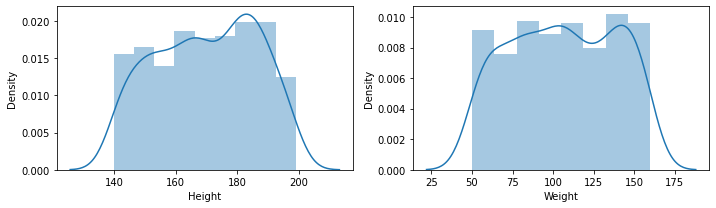

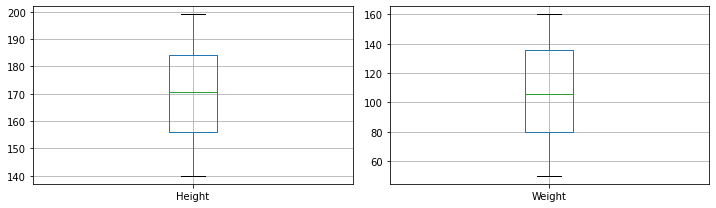

In [111]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

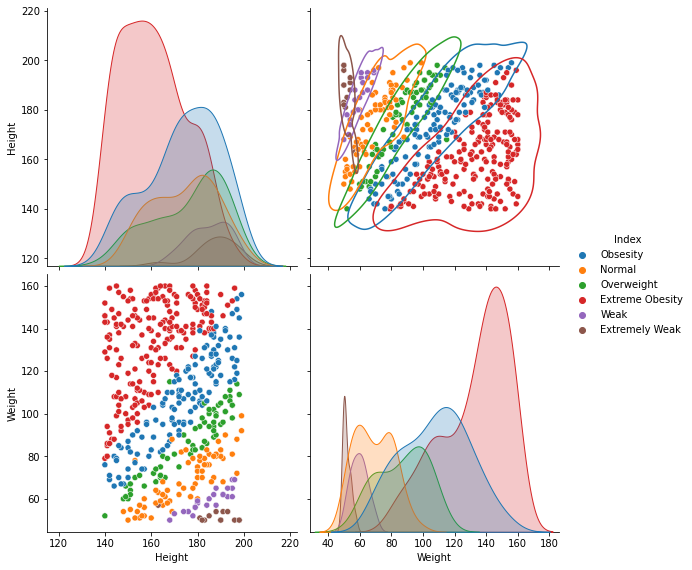

In [112]:
#Understanding the relationship between all the features

g=sns.pairplot(df1, hue=target, size=4)
g.map_upper(sns.kdeplot, levels=1, color=".2")
plt.show()

In [113]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 11


In [114]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

        Total Null Values  Percentage
Gender                  0         0.0
Height                  0         0.0
Weight                  0         0.0
Index                   0         0.0


In [115]:
#Converting categorical Columns to Numeric

#df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

# #Target Variable
# MAP={}
# for i,e in enumerate(df1[target].unique()):
#     MAP[e]=i
# df1[target]=df1[target].map(MAP)
# print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


One-Hot Encoding on features:
Gender


(489, 4)

In [116]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3



Inference: Before removal of outliers, The dataset had 489 samples.
Inference: After removal of outliers, The dataset now has 489 samples.


In [117]:
#Fixing the imbalance using SMOTE Technique

df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
5    195
4    128
2     69
3     64
1     20
0     13
Name: Index, dtype: int64


NameError: name 'SMOTE' is not defined

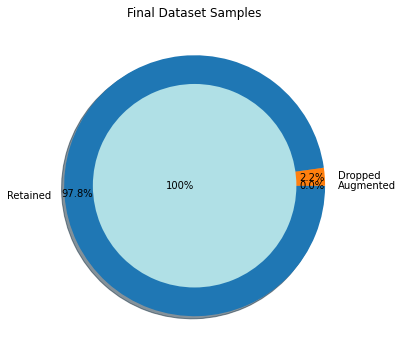


Inference:The final dataset after cleanup has 489 samples & 4 columns.


In [118]:
#Final Dataset size after performing Preprocessing

df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

In [119]:
#Splitting the data intro training & testing sets

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (489, 3) (489,) 
Training set  --->  (391, 3) (391,) 
Testing set   --->  (98, 3)  (98,)


In [120]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,Gender,Height,Weight
count,3.910000e+02,3.910000e+02,3.910000e+02
mean,5.338157e-17,1.445278e-16,2.725867e-17
std,1.001281e+00,1.001281e+00,1.001281e+00
min,-9.525319e-01,-1.823309e+00,-1.725504e+00
25%,-9.525319e-01,-8.408268e-01,-8.254861e-01
50%,-9.525319e-01,1.884558e-02,-1.857344e-02
75%,1.049834e+00,8.785179e-01,9.435148e-01
max,1.049834e+00,1.799595e+00,1.688357e+00



                                Standardardization on Testing set                                


,Gender,Height,Weight
count,98.000000,98.000000,98.000000
mean,0.130380,0.068346,0.120451
std,1.002972,1.024157,1.027611
min,-0.952532,-1.823309,-1.725504
25%,-0.952532,-0.764070,-0.639276
50%,1.049834,0.141656,0.167637
75%,1.049834,0.863167,1.005585
max,1.049834,1.799595,1.688357


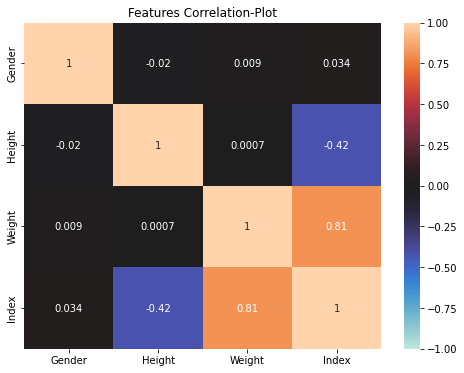

In [121]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[8,6])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True) #, 
plt.show()

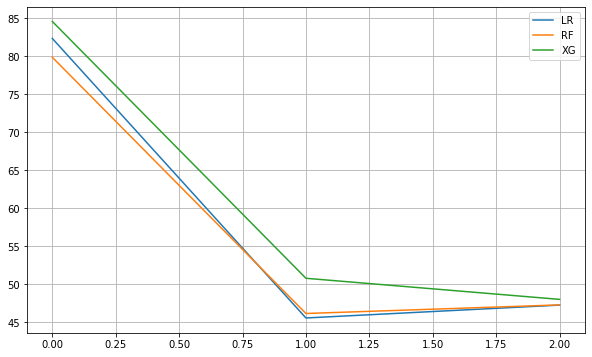

In [122]:
# Calculate the VIFs to remove multicollinearity

DROP=[]; scores1=[]; scores2=[]; scores3=[]
#scores.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std)))
scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        
for i in range(len(X.columns.values)-1):
    vif = pd.DataFrame()
    Xs = X.drop(DROP,axis=1)
    #print(DROP)
    vif['Features'] = Xs.columns
    vif['VIF'] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    DROP.append(vif.Features[0])
    if vif.VIF[0]>1:
        scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
    #print(scores)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.7,0.85])
plt.legend()
plt.grid()
plt.show()

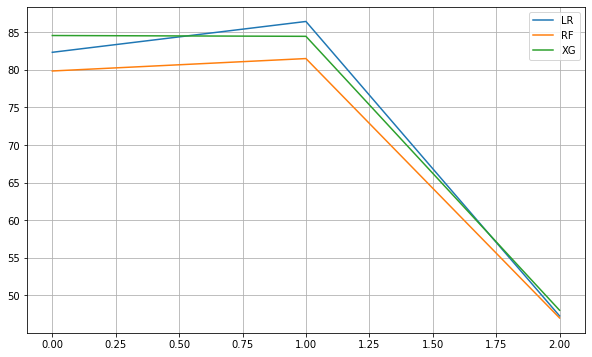

In [123]:
# Applying Recurrsive Feature Elimination

# Running RFE with the output number of the variable equal to 10
LR = LogisticRegression()#.fit(Train_X_std, Train_Y)
scores1=[]; scores2=[]; scores3=[]
# scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std, Train_Y, eval_metric='logloss').predict(Test_X_std),average='weighted')*100)

for i in range(len(X.columns.values)):
    rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns)-i)   
    rfe = rfe.fit(Train_X_std, Train_Y)
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y, eval_metric='logloss').predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.80,0.84])
plt.legend()
plt.grid()
plt.show()

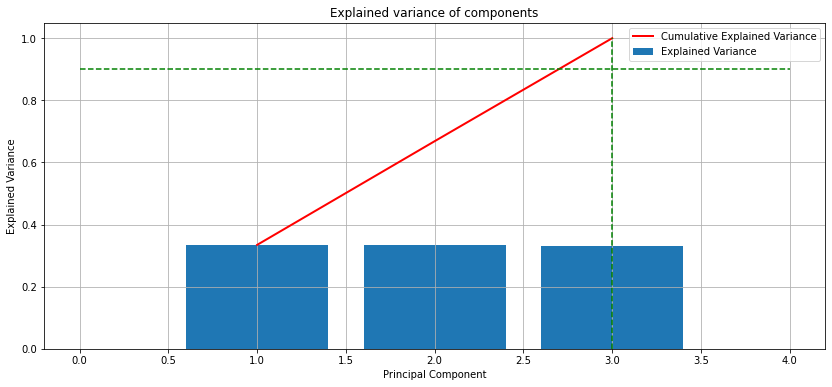

In [124]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([3,3],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

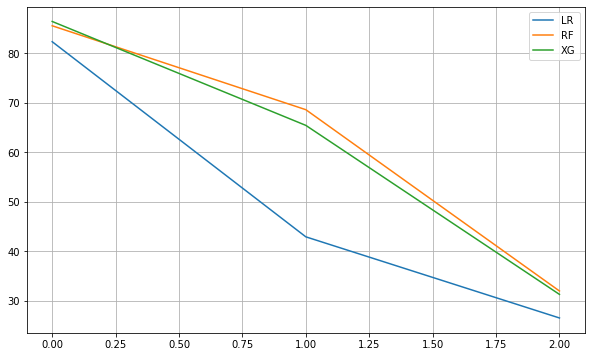

In [125]:
#Applying PCA Transformations

# scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std, Train_Y, eval_metric='logloss').predict(Test_X_std),average='weighted')*100)

scores1=[]; scores2=[]; scores3=[]
for i in range(len(X.columns.values)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    #print('The shape of final transformed training feature set:')
    #print(Train_X_std_pca.shape)
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca)

    Test_X_std_pca = pca.transform(Test_X_std)
    #print('\nThe shape of final transformed testing feature set:')
    #print(Test_X_std_pca.shape)
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std_pca, Train_Y, eval_metric='logloss').predict(Test_X_std_pca),average='weighted')*100)

    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.80,0.84])
plt.legend()
plt.grid()
plt.show()


In [126]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((8,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)', 'Gradient Boosting (GB)','Extreme Gradient Boosting (XGB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0
Gradient Boosting (GB),0.0,0.0,0.0,0.0,0.0
Extreme Gradient Boosting (XGB),0.0,0.0,0.0,0.0,0.0


In [127]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob, multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 80.60000000000001%
F1 Score = 79.80000000000001%

 Confusiton Matrix:
 [[ 2  0  1  0  0  0]
 [ 0  3  2  0  0  0]
 [ 0  2  8  2  0  0]
 [ 0  0  1  3  4  0]
 [ 0  0  0  0 23  6]
 [ 0  0  0  0  1 40]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.60      0.60      0.60         5
           2       0.67      0.67      0.67        12
           3       0.60      0.38      0.46         8
           4       0.82      0.79      0.81        29
           5       0.87      0.98      0.92        41

    accuracy                           0.81        98
   macro avg       0.76      0.68      0.71        98
weighted avg       0.80      0.81      0.80        98



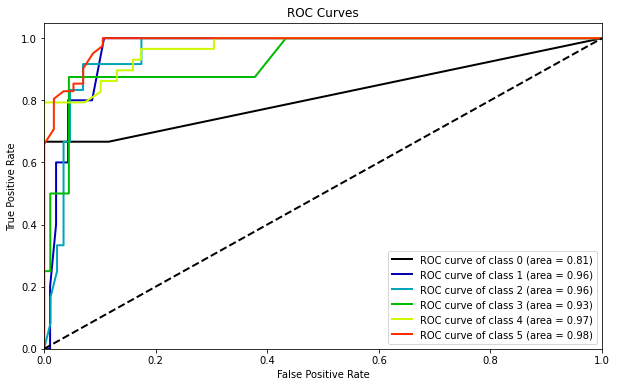


Interpreting the output of Random Forest:



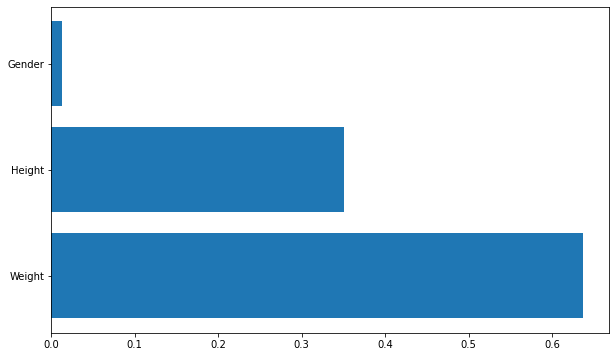

In [128]:
# Building Random-Forest Classifier

RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 55.1%
F1 Score = 54.0%

 Confusiton Matrix:
 [[ 0  0  3  0  0  0]
 [ 0  0  3  2  0  0]
 [ 0  0  8  4  0  0]
 [ 0  0  4  4  0  0]
 [ 0  0  7  2 10 10]
 [ 0  0  5  0  4 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         5
           2       0.27      0.67      0.38        12
           3       0.33      0.50      0.40         8
           4       0.71      0.34      0.47        29
           5       0.76      0.78      0.77        41

    accuracy                           0.55        98
   macro avg       0.35      0.38      0.34        98
weighted avg       0.59      0.55      0.54        98



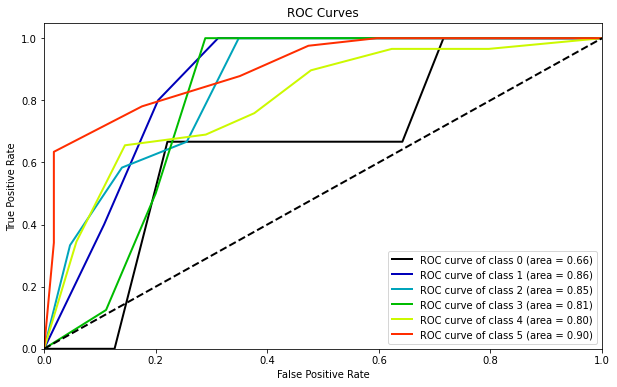

In [129]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,3)

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 84.7%
F1 Score = 84.39999999999999%

 Confusiton Matrix:
 [[ 2  0  1  0  0  0]
 [ 0  3  2  0  0  0]
 [ 0  2  8  2  0  0]
 [ 0  0  1  5  2  0]
 [ 0  0  0  0 25  4]
 [ 0  0  0  0  1 40]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.60      0.60      0.60         5
           2       0.67      0.67      0.67        12
           3       0.71      0.62      0.67         8
           4       0.89      0.86      0.88        29
           5       0.91      0.98      0.94        41

    accuracy                           0.85        98
   macro avg       0.80      0.73      0.76        98
weighted avg       0.85      0.85      0.84        98



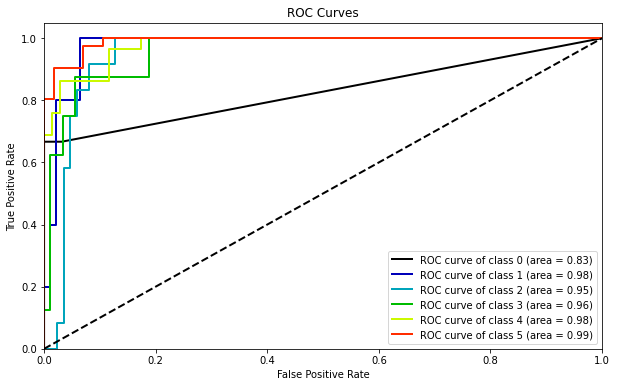

In [130]:
# Building K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)

<<<----------------------------------- Evaluating Gradient Boosting (GB) ----------------------------------->>>

Accuracy = 80.60000000000001%
F1 Score = 80.7%

 Confusiton Matrix:
 [[ 2  0  1  0  0  0]
 [ 0  3  2  0  0  0]
 [ 0  1  8  3  0  0]
 [ 0  0  1  5  2  0]
 [ 0  0  1  1 23  4]
 [ 0  0  0  0  3 38]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      0.60      0.67         5
           2       0.62      0.67      0.64        12
           3       0.56      0.62      0.59         8
           4       0.82      0.79      0.81        29
           5       0.90      0.93      0.92        41

    accuracy                           0.81        98
   macro avg       0.77      0.71      0.74        98
weighted avg       0.81      0.81      0.81        98



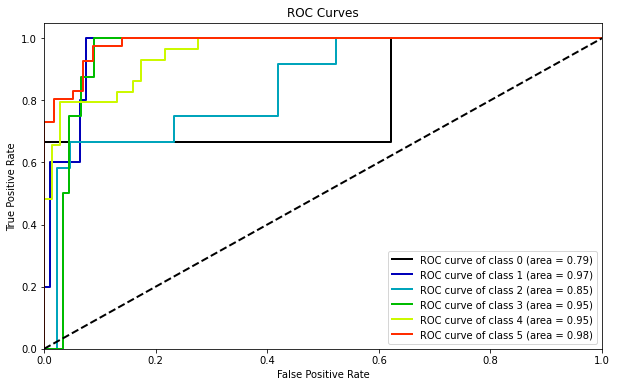

In [131]:
# Building Gradient Boosting Classifier

GB_model = GradientBoostingClassifier().fit(Train_X_std, Train_Y)
param_dist = {
    "n_estimators":[5,20,100,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, param_dist, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=5, random_state=1)

GB = GB_model.fit(Train_X_std, Train_Y)#.best_estimator_
pred = GB.predict(Test_X_std)
pred_prob = GB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,6)

<<<----------------------------------- Evaluating Extreme Gradient Boosting (XGB) ----------------------------------->>>

Accuracy = 84.7%
F1 Score = 84.6%

 Confusiton Matrix:
 [[ 2  0  1  0  0  0]
 [ 0  3  2  0  0  0]
 [ 0  1  8  3  0  0]
 [ 0  0  1  6  1  0]
 [ 0  0  0  0 25  4]
 [ 0  0  0  0  2 39]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      0.60      0.67         5
           2       0.67      0.67      0.67        12
           3       0.67      0.75      0.71         8
           4       0.89      0.86      0.88        29
           5       0.91      0.95      0.93        41

    accuracy                           0.85        98
   macro avg       0.81      0.75      0.77        98
weighted avg       0.85      0.85      0.85        98



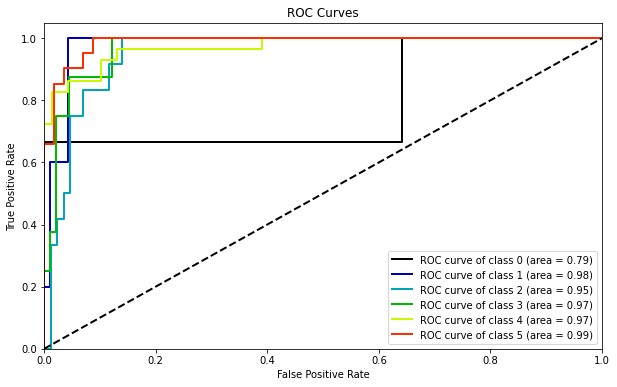

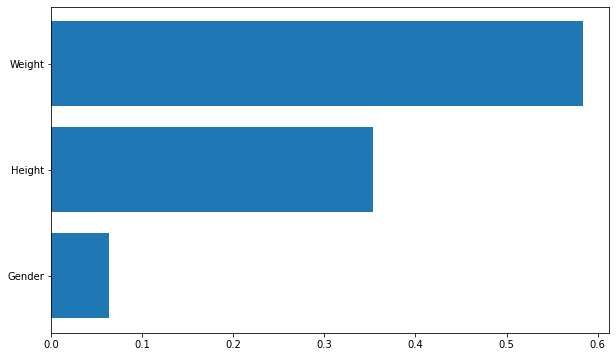

In [132]:
# Building Extreme Gradient Boosting Classifier

XGB_model = XGBClassifier()#.fit(Train_X_std, Train_Y, eval_metric='logloss')

param_dist = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#RCV = RandomizedSearchCV(XGB_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

XGB = XGB_model.fit(Train_X_std, Train_Y, eval_metric='logloss')#.best_estimator_
pred = XGB.predict(Test_X_std)
pred_prob = XGB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,7)

xgbf=pd.DataFrame(XGB.feature_importances_, index=Train_X_std.columns).sort_values(by=0)
plt.barh(xgbf.index,xgbf.values[:,0])
plt.show()

                                    ML Algorithms Comparison                                    


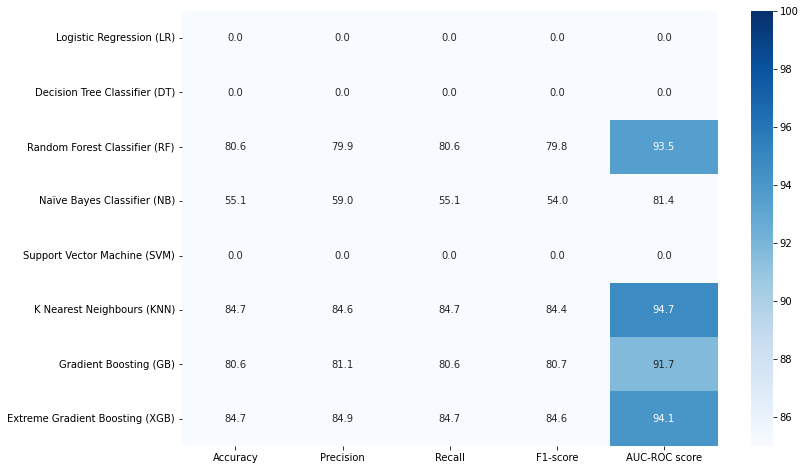

In [135]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=85, vmax=100, cmap='Blues', fmt='.1f')
plt.show()

In [136]:
df.head()

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


In [137]:
for i  in df.columns:
    print(f'unique values in column "{i}" is\n {df[i].value_counts()}')
    print('-------------------------------------------------')

unique values in column "Gender" is
 0    250
1    239
Name: Gender, dtype: int64
-------------------------------------------------
unique values in column "Height" is
 188    15
187    14
178    13
179    13
168    13
172    12
184    12
181    11
182    11
185    11
183    11
150    11
157    10
153    10
169    10
154    10
165    10
161     9
146     9
159     9
190     9
145     9
162     9
195     9
186     9
166     9
177     8
180     8
142     8
167     8
164     8
152     8
140     8
151     8
163     8
176     7
171     7
147     7
160     7
197     7
174     7
141     7
191     6
156     6
196     6
170     6
192     6
155     6
148     5
149     5
189     5
158     5
144     5
194     5
193     5
198     5
173     4
175     4
199     3
143     3
Name: Height, dtype: int64
-------------------------------------------------
unique values in column "Weight" is
 50     9
96     8
80     8
140    8
154    8
      ..
63     1
91     1
112    1
55     1
53     1
Name: Weight, Leng

In [138]:
df.skew()

Gender    0.045140
Height   -0.111068
Weight   -0.059284
Index    -0.940327
dtype: float64

In [139]:
df=df.drop(['Index'],axis='columns')

In [140]:
x=df.drop(['Gender'],axis='columns')
y=df.Gender.values

In [142]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=0)

In [143]:
tre=DecisionTreeClassifier()
tre.fit(xtrain,ytrain)
pred_tre=tre.predict(xtest)
accu_tre=accuracy_score(ytest,pred_tre)*100
accu_tre

52.38095238095239

In [144]:
print(classification_report(ytest,pred_tre))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53        70
           1       0.55      0.49      0.52        77

    accuracy                           0.52       147
   macro avg       0.53      0.53      0.52       147
weighted avg       0.53      0.52      0.52       147



In [145]:
kne=KNeighborsClassifier()
kne.fit(xtrain,ytrain)
pred_kne=kne.predict(xtest)
accu_kne=accuracy_score(ytest,pred_kne)*100
accu_kne

53.06122448979592

In [146]:
print(classification_report(ytest,pred_kne))

              precision    recall  f1-score   support

           0       0.51      0.56      0.53        70
           1       0.56      0.51      0.53        77

    accuracy                           0.53       147
   macro avg       0.53      0.53      0.53       147
weighted avg       0.53      0.53      0.53       147



In [147]:
lo=LogisticRegression()
lo.fit(xtrain,ytrain)
pred_lo=lo.predict(xtest)
accu_lo=accuracy_score(ytest,pred_lo)*100
accu_lo

47.61904761904761

In [148]:
print(classification_report(ytest,pred_lo))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        70
           1       0.00      0.00      0.00        77

    accuracy                           0.48       147
   macro avg       0.24      0.50      0.32       147
weighted avg       0.23      0.48      0.31       147



In [149]:
from sklearn.ensemble import AdaBoostClassifier

In [150]:
ada=AdaBoostClassifier()
ada.fit(xtrain,ytrain)
pred_ada=ada.predict(xtest)
accu_ada=accuracy_score(ytest,pred_ada)*100
accu_ada

50.34013605442177

In [151]:
print(classification_report(ytest,pred_ada))

              precision    recall  f1-score   support

           0       0.48      0.51      0.50        70
           1       0.53      0.49      0.51        77

    accuracy                           0.50       147
   macro avg       0.50      0.50      0.50       147
weighted avg       0.51      0.50      0.50       147



In [152]:
from sklearn.ensemble import BaggingClassifier

In [153]:
bag=BaggingClassifier()
bag.fit(xtrain,ytrain)
pred_bag=bag.predict(xtest)
accu_bag=accuracy_score(ytest,pred_bag)*100
accu_bag

54.421768707483

In [154]:
print(classification_report(ytest,pred_bag))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57        70
           1       0.58      0.45      0.51        77

    accuracy                           0.54       147
   macro avg       0.55      0.55      0.54       147
weighted avg       0.55      0.54      0.54       147



In [155]:
from sklearn.naive_bayes import GaussianNB

In [156]:
gau=GaussianNB()
gau.fit(xtrain,ytrain)
pred_gau=gau.predict(xtest)
accu_l=accuracy_score(ytest,pred_gau)*100
accu_l

48.29931972789115

In [157]:
print(classification_report(ytest,pred_gau))

              precision    recall  f1-score   support

           0       0.48      0.91      0.63        70
           1       0.54      0.09      0.16        77

    accuracy                           0.48       147
   macro avg       0.51      0.50      0.39       147
weighted avg       0.51      0.48      0.38       147



In [158]:
from sklearn.ensemble import ExtraTreesClassifier

In [159]:
etc=ExtraTreesClassifier()
etc.fit(xtrain,ytrain)
pred_etc=etc.predict(xtest)
accu_etc=accuracy_score(ytest,pred_etc)*100
accu_etc

54.421768707483

In [160]:
print(classification_report(ytest,pred_etc))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57        70
           1       0.58      0.45      0.51        77

    accuracy                           0.54       147
   macro avg       0.55      0.55      0.54       147
weighted avg       0.55      0.54      0.54       147



In [161]:
from sklearn.svm import SVC

In [162]:
svc=SVC()
svc.fit(xtrain,ytrain)
pred_svc=svc.predict(xtest)
accu_svc=accuracy_score(ytest,pred_svc)*100
accu_svc

46.93877551020408

In [163]:
print(classification_report(ytest,pred_svc))

              precision    recall  f1-score   support

           0       0.47      0.99      0.64        70
           1       0.00      0.00      0.00        77

    accuracy                           0.47       147
   macro avg       0.24      0.49      0.32       147
weighted avg       0.23      0.47      0.30       147



In [164]:
from sklearn.ensemble import RandomForestClassifier

In [165]:
rnd=RandomForestClassifier()
rnd.fit(xtrain,ytrain)
pred_rnd=rnd.predict(xtest)
accu_rnd=accuracy_score(ytest,pred_rnd)*100
accu_rnd

51.70068027210885

In [166]:
print(classification_report(ytest,pred_rnd))

              precision    recall  f1-score   support

           0       0.49      0.57      0.53        70
           1       0.55      0.47      0.50        77

    accuracy                           0.52       147
   macro avg       0.52      0.52      0.52       147
weighted avg       0.52      0.52      0.52       147



In [167]:
from catboost import CatBoostClassifier

In [168]:
cat=CatBoostClassifier()
cat.fit(xtrain,ytrain)

Learning rate set to 0.006516
0:	learn: 0.6929148	total: 327ms	remaining: 5m 26s
1:	learn: 0.6926213	total: 332ms	remaining: 2m 45s
2:	learn: 0.6923771	total: 335ms	remaining: 1m 51s
3:	learn: 0.6919591	total: 339ms	remaining: 1m 24s
4:	learn: 0.6919225	total: 341ms	remaining: 1m 7s
5:	learn: 0.6916290	total: 344ms	remaining: 57s
6:	learn: 0.6914817	total: 347ms	remaining: 49.2s
7:	learn: 0.6910126	total: 349ms	remaining: 43.3s
8:	learn: 0.6908436	total: 351ms	remaining: 38.6s
9:	learn: 0.6907244	total: 353ms	remaining: 34.9s
10:	learn: 0.6906073	total: 354ms	remaining: 31.8s
11:	learn: 0.6902985	total: 356ms	remaining: 29.3s
12:	learn: 0.6901426	total: 358ms	remaining: 27.1s
13:	learn: 0.6899946	total: 359ms	remaining: 25.3s
14:	learn: 0.6897552	total: 361ms	remaining: 23.7s
15:	learn: 0.6894170	total: 362ms	remaining: 22.3s
16:	learn: 0.6892624	total: 364ms	remaining: 21s
17:	learn: 0.6890759	total: 365ms	remaining: 19.9s
18:	learn: 0.6888017	total: 367ms	remaining: 19s
19:	learn: 0.

197:	learn: 0.6570403	total: 653ms	remaining: 2.64s
198:	learn: 0.6568985	total: 655ms	remaining: 2.63s
199:	learn: 0.6567126	total: 656ms	remaining: 2.63s
200:	learn: 0.6565310	total: 658ms	remaining: 2.62s
201:	learn: 0.6563238	total: 660ms	remaining: 2.6s
202:	learn: 0.6560876	total: 661ms	remaining: 2.6s
203:	learn: 0.6559290	total: 663ms	remaining: 2.59s
204:	learn: 0.6558799	total: 665ms	remaining: 2.58s
205:	learn: 0.6556688	total: 668ms	remaining: 2.57s
206:	learn: 0.6554618	total: 670ms	remaining: 2.56s
207:	learn: 0.6553488	total: 671ms	remaining: 2.56s
208:	learn: 0.6553303	total: 673ms	remaining: 2.54s
209:	learn: 0.6551792	total: 674ms	remaining: 2.54s
210:	learn: 0.6550254	total: 676ms	remaining: 2.53s
211:	learn: 0.6549239	total: 677ms	remaining: 2.52s
212:	learn: 0.6548035	total: 680ms	remaining: 2.51s
213:	learn: 0.6545440	total: 682ms	remaining: 2.5s
214:	learn: 0.6543769	total: 684ms	remaining: 2.5s
215:	learn: 0.6541977	total: 686ms	remaining: 2.49s
216:	learn: 0.65

393:	learn: 0.6315760	total: 959ms	remaining: 1.48s
394:	learn: 0.6314869	total: 961ms	remaining: 1.47s
395:	learn: 0.6314151	total: 962ms	remaining: 1.47s
396:	learn: 0.6312488	total: 964ms	remaining: 1.46s
397:	learn: 0.6310468	total: 965ms	remaining: 1.46s
398:	learn: 0.6309765	total: 967ms	remaining: 1.46s
399:	learn: 0.6308745	total: 969ms	remaining: 1.45s
400:	learn: 0.6307275	total: 970ms	remaining: 1.45s
401:	learn: 0.6306559	total: 972ms	remaining: 1.45s
402:	learn: 0.6305760	total: 974ms	remaining: 1.44s
403:	learn: 0.6303939	total: 975ms	remaining: 1.44s
404:	learn: 0.6303492	total: 977ms	remaining: 1.44s
405:	learn: 0.6301860	total: 979ms	remaining: 1.43s
406:	learn: 0.6300437	total: 981ms	remaining: 1.43s
407:	learn: 0.6297211	total: 982ms	remaining: 1.43s
408:	learn: 0.6295487	total: 984ms	remaining: 1.42s
409:	learn: 0.6294537	total: 986ms	remaining: 1.42s
410:	learn: 0.6293292	total: 987ms	remaining: 1.41s
411:	learn: 0.6290916	total: 989ms	remaining: 1.41s
412:	learn: 

561:	learn: 0.6112559	total: 1.25s	remaining: 978ms
562:	learn: 0.6110493	total: 1.26s	remaining: 975ms
563:	learn: 0.6109657	total: 1.26s	remaining: 973ms
564:	learn: 0.6108618	total: 1.26s	remaining: 970ms
565:	learn: 0.6107807	total: 1.26s	remaining: 968ms
566:	learn: 0.6106922	total: 1.26s	remaining: 965ms
567:	learn: 0.6105556	total: 1.26s	remaining: 962ms
568:	learn: 0.6104800	total: 1.27s	remaining: 960ms
569:	learn: 0.6103662	total: 1.27s	remaining: 957ms
570:	learn: 0.6102998	total: 1.27s	remaining: 954ms
571:	learn: 0.6101579	total: 1.27s	remaining: 952ms
572:	learn: 0.6099954	total: 1.27s	remaining: 949ms
573:	learn: 0.6098674	total: 1.27s	remaining: 947ms
574:	learn: 0.6097301	total: 1.28s	remaining: 944ms
575:	learn: 0.6096527	total: 1.28s	remaining: 941ms
576:	learn: 0.6095456	total: 1.28s	remaining: 939ms
577:	learn: 0.6094275	total: 1.28s	remaining: 937ms
578:	learn: 0.6092817	total: 1.28s	remaining: 934ms
579:	learn: 0.6092198	total: 1.29s	remaining: 932ms
580:	learn: 

745:	learn: 0.5922357	total: 1.55s	remaining: 529ms
746:	learn: 0.5921542	total: 1.55s	remaining: 526ms
747:	learn: 0.5920354	total: 1.55s	remaining: 524ms
748:	learn: 0.5919994	total: 1.56s	remaining: 522ms
749:	learn: 0.5919033	total: 1.56s	remaining: 520ms
750:	learn: 0.5918124	total: 1.56s	remaining: 517ms
751:	learn: 0.5917502	total: 1.56s	remaining: 515ms
752:	learn: 0.5916396	total: 1.56s	remaining: 513ms
753:	learn: 0.5915624	total: 1.56s	remaining: 511ms
754:	learn: 0.5914293	total: 1.57s	remaining: 508ms
755:	learn: 0.5913559	total: 1.57s	remaining: 506ms
756:	learn: 0.5912063	total: 1.57s	remaining: 504ms
757:	learn: 0.5910217	total: 1.57s	remaining: 502ms
758:	learn: 0.5909722	total: 1.57s	remaining: 500ms
759:	learn: 0.5908628	total: 1.57s	remaining: 497ms
760:	learn: 0.5908048	total: 1.58s	remaining: 495ms
761:	learn: 0.5907434	total: 1.58s	remaining: 493ms
762:	learn: 0.5906130	total: 1.58s	remaining: 491ms
763:	learn: 0.5904111	total: 1.58s	remaining: 489ms
764:	learn: 

912:	learn: 0.5742116	total: 1.86s	remaining: 177ms
913:	learn: 0.5740568	total: 1.86s	remaining: 175ms
914:	learn: 0.5740173	total: 1.86s	remaining: 173ms
915:	learn: 0.5739566	total: 1.87s	remaining: 171ms
916:	learn: 0.5738418	total: 1.87s	remaining: 169ms
917:	learn: 0.5737709	total: 1.87s	remaining: 167ms
918:	learn: 0.5736605	total: 1.87s	remaining: 165ms
919:	learn: 0.5735928	total: 1.87s	remaining: 163ms
920:	learn: 0.5734613	total: 1.87s	remaining: 161ms
921:	learn: 0.5733550	total: 1.88s	remaining: 159ms
922:	learn: 0.5732445	total: 1.88s	remaining: 157ms
923:	learn: 0.5731339	total: 1.88s	remaining: 155ms
924:	learn: 0.5729618	total: 1.88s	remaining: 153ms
925:	learn: 0.5728954	total: 1.88s	remaining: 151ms
926:	learn: 0.5727906	total: 1.89s	remaining: 149ms
927:	learn: 0.5727701	total: 1.89s	remaining: 146ms
928:	learn: 0.5725998	total: 1.89s	remaining: 144ms
929:	learn: 0.5724079	total: 1.89s	remaining: 142ms
930:	learn: 0.5723029	total: 1.89s	remaining: 140ms
931:	learn: 

In [169]:
cat.score(xtest,ytest)*100

55.10204081632652

In [170]:
models = pd.DataFrame({
    'Model': ['LogisticRegression','DecisionTreeClassifier','KNeighborsClassifier' , 
             'AdaBoostClassifier','BaggingClassifier','GaussianNB','AdaBoostClassifier','ExtraTreesClassifier','SVM','RandomForestClassifier'],
    'Score': [accu_lo,accu_tre, accu_kne, accu_ada,accu_bag,accu_l,accu_ada,accu_etc,accu_svc,accu_rnd]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
4,BaggingClassifier,54.421769
7,ExtraTreesClassifier,54.421769
2,KNeighborsClassifier,53.061224
1,DecisionTreeClassifier,52.380952
9,RandomForestClassifier,51.700680
3,AdaBoostClassifier,50.340136
6,AdaBoostClassifier,50.340136
5,GaussianNB,48.299320
0,LogisticRegression,47.619048
8,SVM,46.938776


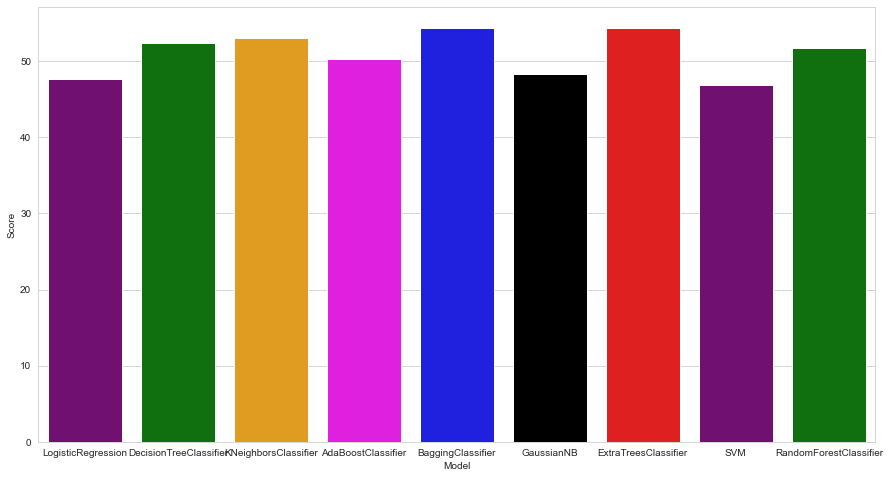

In [171]:
colors = ["purple", "green", "orange", "magenta","blue","black","red"]

sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=models['Model'],y=models['Score'], palette=colors )
plt.show()

In [172]:
df.head()

,Gender,Height,Weight
0,1,174,96
1,1,189,87
2,0,185,110
3,0,195,104
4,1,149,61


In [173]:
import sklearn.cluster as cluster
from sklearn.cluster import KMeans

In [174]:
kmns=cluster.KMeans(n_clusters=5)
kmns.fit(df[['Gender','Height']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [175]:
kmns.cluster_centers_

array([[  0.43137255, 168.24509804],
       [  0.49484536, 156.4742268 ],
       [  0.50961538, 191.31730769],
       [  0.54545455, 145.12987013],
       [  0.47706422, 180.53211009]])

In [176]:
k_range=range(1,15)
wss=[]

In [177]:
for k in k_range:
    km=KMeans(n_clusters=k)
    km.fit(df[['Gender','Height']])
    wss.append(km.inertia_)

In [178]:
wss

[130899.75051124745,
 33116.09663654619,
 15332.218247897763,
 9091.128640747605,
 5864.966860344262,
 4170.033307157958,
 2866.527413706156,
 2246.220010198456,
 1932.9745837317466,
 1513.2391980577308,
 1286.2613830538123,
 1048.244296948214,
 930.120551609718,
 803.4628475282275]

In [179]:
df['Gender by Height']=kmns.labels_

In [180]:
kmns=cluster.KMeans(n_clusters=5)
kmns.fit(df[['Gender','Weight']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [181]:
kmns.cluster_centers_

array([[  0.45783133, 126.62650602],
       [  0.52941176,  82.56470588],
       [  0.5       , 148.38135593],
       [  0.43157895,  60.18947368],
       [  0.51851852, 104.28703704]])

In [182]:
k_range=range(1,9)
wss=[]

In [186]:
for k in k_range:
    km=KMeans(n_clusters=k)
    km.fit(df[['Gender','Weight']])
    wss.append(km.inertia_)

In [187]:
wss

[513596.9529652352,
 132923.64222147875,
 54184.49007960383,
 31487.65482347188,
 20065.944225225227,
 14158.42469932892,
 10221.225553751803,
 7551.686773527736]

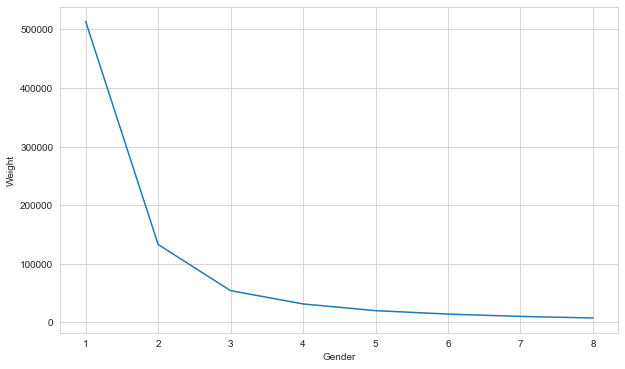

In [188]:
plt.xlabel('Gender')
plt.ylabel('Weight')
plt.plot(k_range,wss)

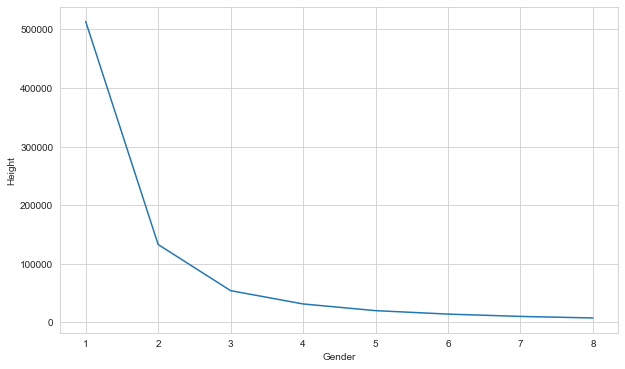

In [189]:
plt.xlabel('Gender')
plt.ylabel('Height')
plt.plot(k_range,wss)

In [190]:
df.head()

,Gender,Height,Weight,Gender by Height
0,1,174,96,0
1,1,189,87,2
2,0,185,110,4
3,0,195,104,2
4,1,149,61,3


In [191]:
df.columns

Index(['Gender', 'Height', 'Weight', 'Gender by Height'], dtype='object')

<AxesSubplot:>

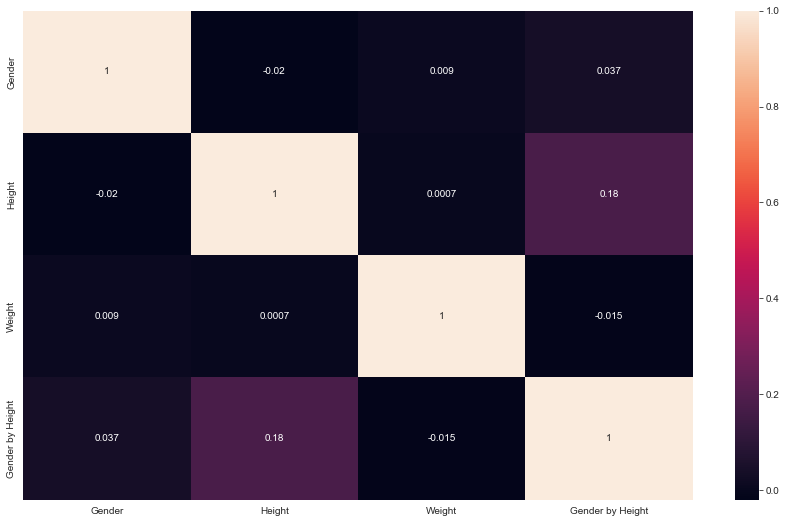

In [192]:
plt.figure(figsize=(15,9))
sns.heatmap(df.corr(),annot=True)

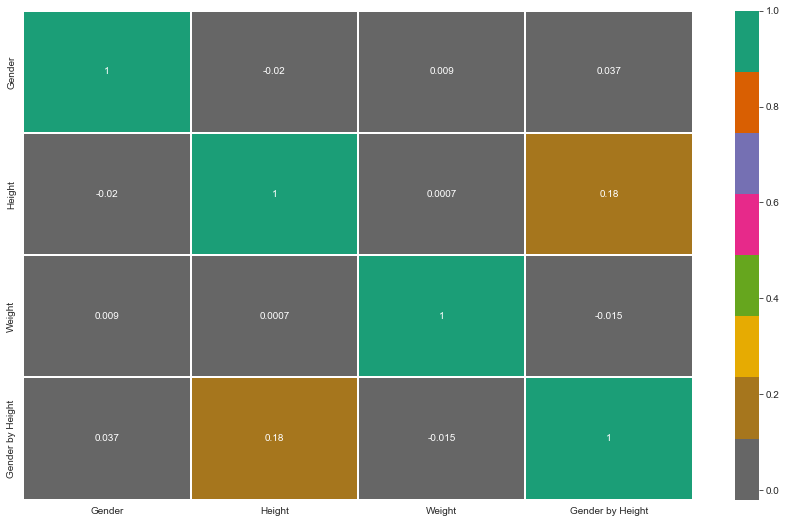

In [193]:
plt.figure(figsize=(15,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(),annot=True,cmap='Dark2_r',linewidths=2)
plt.show()

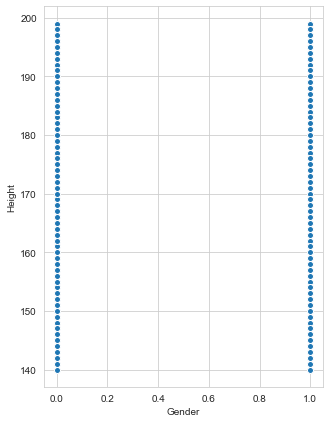

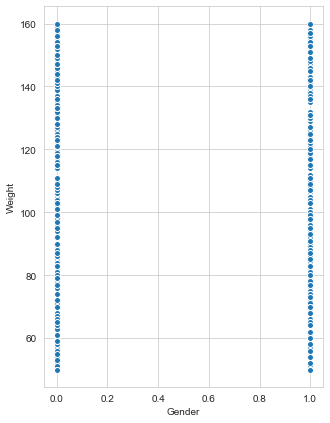

In [194]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.scatterplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

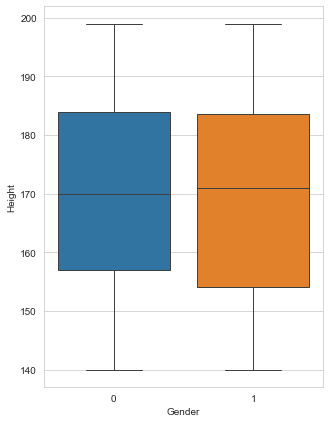

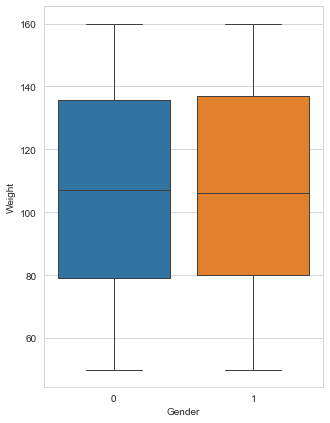

In [195]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.boxplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

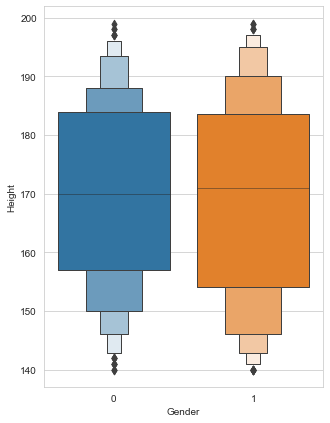

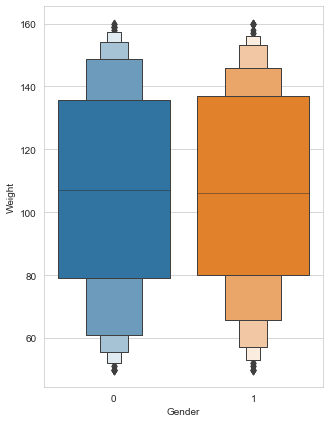

In [196]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.boxenplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

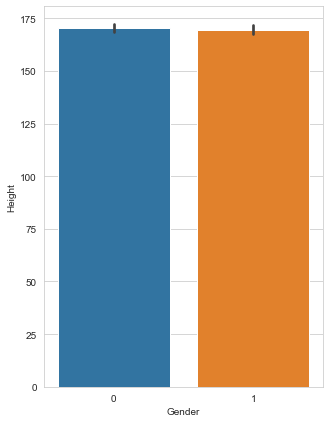

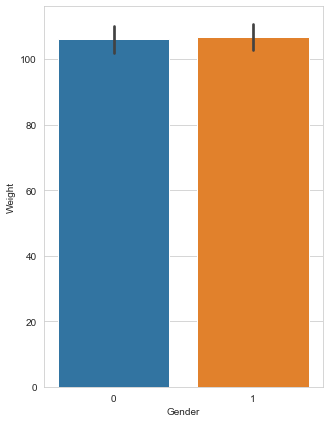

In [197]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.barplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

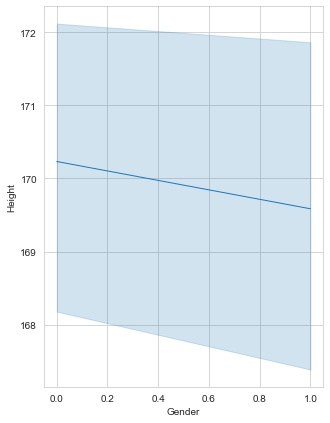

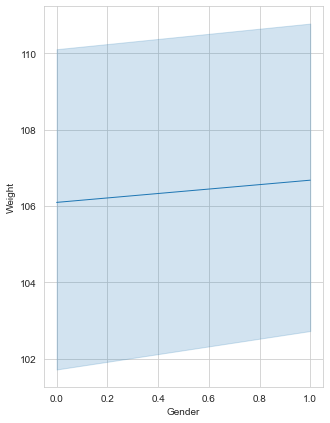

In [198]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.lineplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

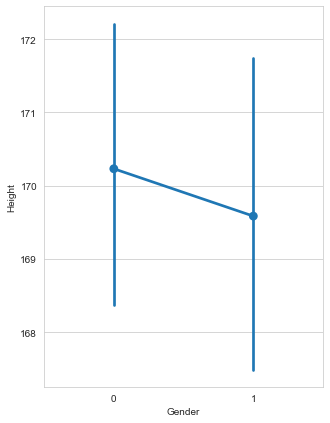

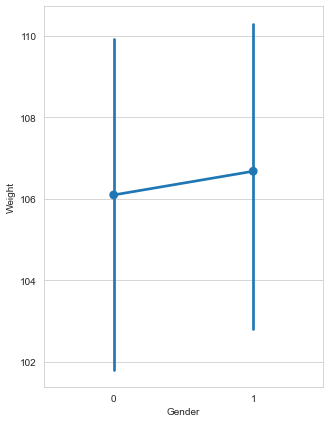

In [200]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.pointplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

<Figure size 360x504 with 0 Axes>

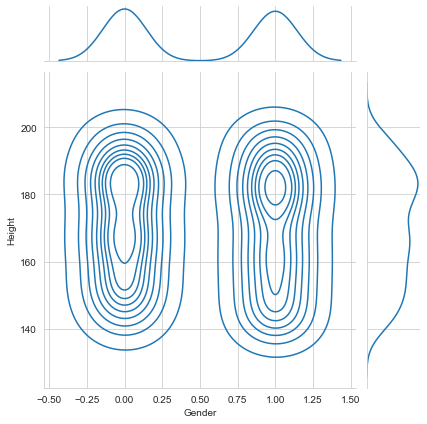

<Figure size 360x504 with 0 Axes>

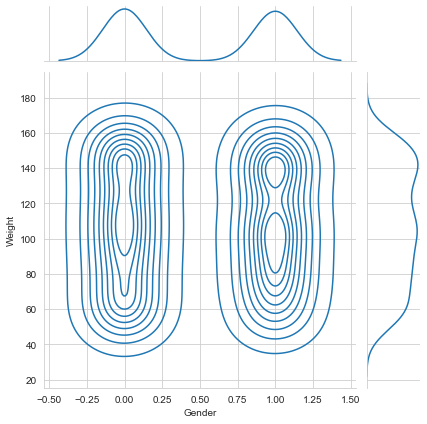

In [202]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.jointplot(x=df.Gender,y=df[i],data=df,linewidth=1,kind='kde')
    plt.show()

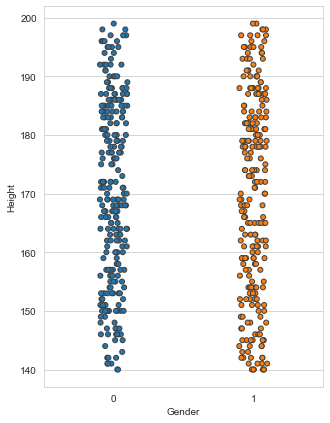

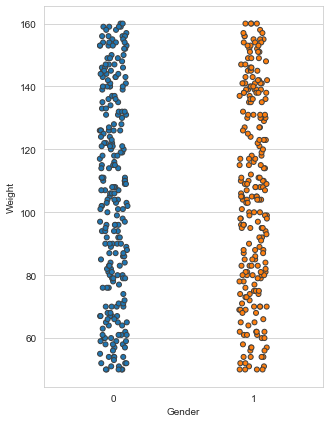

In [203]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.stripplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

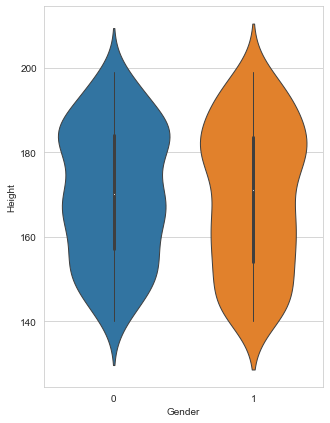

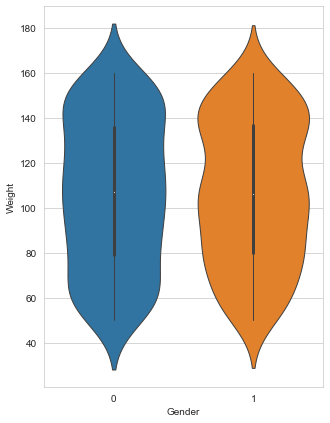

In [204]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.violinplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

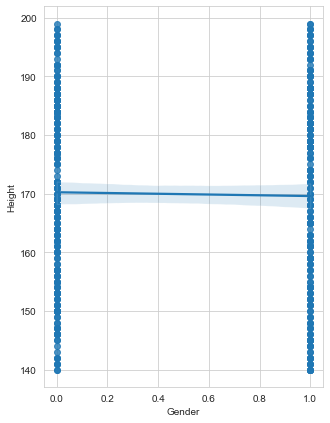

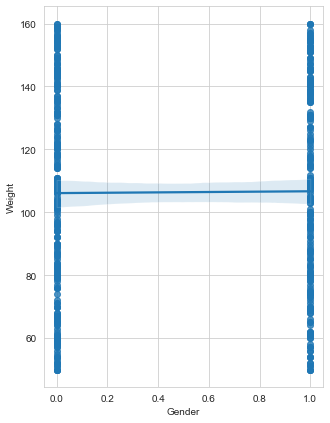

In [206]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.regplot(x=df.Gender,y=df[i],data=df)
    plt.show()

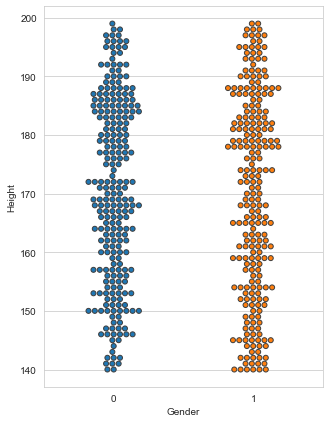

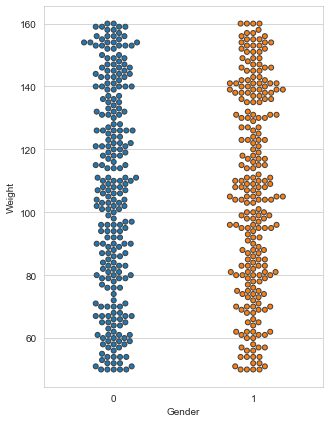

In [207]:
for i in ['Height', 'Weight']:
    plt.figure(figsize=(5,7))
    sns.swarmplot(x=df.Gender,y=df[i],data=df,linewidth=1)
    plt.show()

<AxesSubplot:xlabel='Gender', ylabel='Density'>

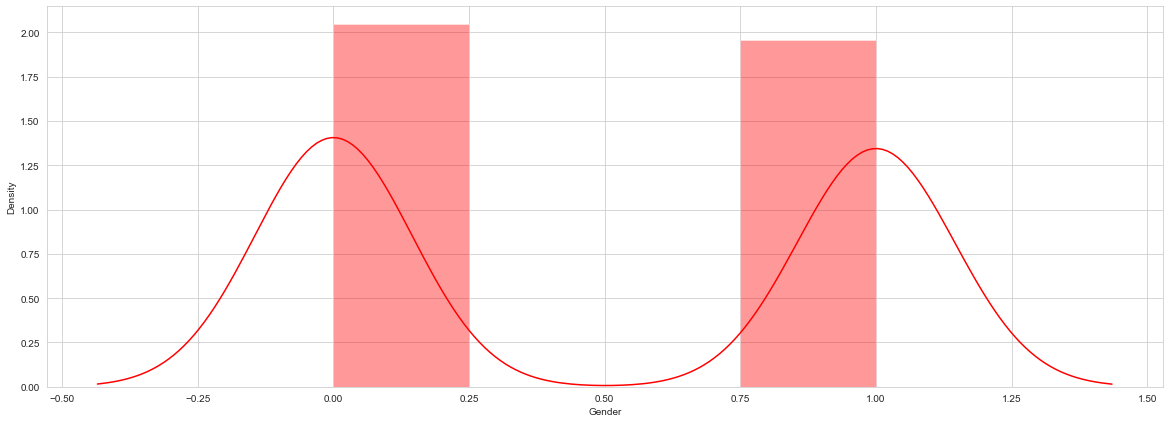

In [208]:
plt.figure(figsize=(20,7))
sns.distplot(df['Gender'],color='red')

In [209]:
df.columns

Index(['Gender', 'Height', 'Weight', 'Gender by Height'], dtype='object')

<AxesSubplot:>

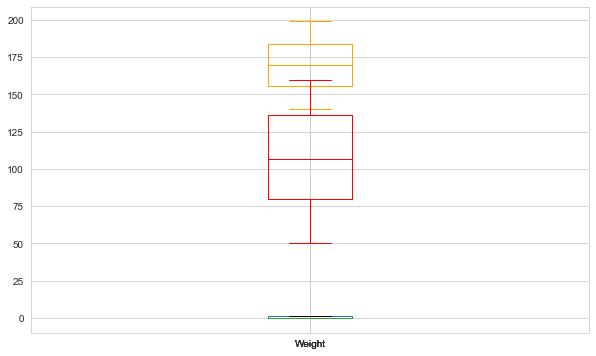

In [210]:
df.boxplot(column="Gender")
df.boxplot(column="Height",color='orange')
df.boxplot(column="Weight",color='red')

In [211]:
import sweetviz as sv

In [212]:
data=sv.analyze(df)
data.show_html('Analyze.html')

                                             |                                             | [  0%]   00:00 ->…

Report Analyze.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [213]:
from IPython.display import IFrame

In [214]:
IFrame(src='Analyze.html',width=1000,height=600)

In [215]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [216]:
man=MinMaxScaler()
feat=['Gender', 'Height', 'Weight', 'Gender by Height']
df[feat]=man.fit_transform(df[feat])
df[feat]

,Gender,Height,Weight,Gender by Height
0,1.0,0.576271,0.418182,0.00
1,1.0,0.830508,0.336364,0.50
2,0.0,0.762712,0.545455,1.00
3,0.0,0.932203,0.490909,0.50
4,1.0,0.152542,0.100000,0.75
...,...,...,...,...
484,0.0,0.169492,0.936364,0.75
485,0.0,0.745763,0.645455,1.00
486,0.0,0.016949,0.781818,0.75
487,1.0,0.169492,0.409091,0.75


In [217]:
std=StandardScaler()
feat=['Gender', 'Height', 'Weight', 'Gender by Height']
df[feat]=std.fit_transform(df[feat])
df[feat]

,Gender,Height,Weight,Gender by Height
0,1.022754,0.249722,-0.320211,-1.377697
1,1.022754,1.166954,-0.597951,0.008504
2,-0.977753,0.922359,0.111828,1.394705
3,-0.977753,1.533847,-0.073332,0.008504
4,1.022754,-1.278997,-1.400309,0.701605
...,...,...,...,...
484,-0.977753,-1.217849,1.438805,0.701605
485,-0.977753,0.861210,0.451287,1.394705
486,-0.977753,-1.768188,0.914186,0.701605
487,1.022754,-1.217849,-0.351071,0.701605
